In [1]:
# !git clone https://github.com/vincentnam/ProjetInterpromo2020G8.git

In [156]:
from abc import ABCMeta, abstractmethod
from typing import Iterable

import numpy as np
from pipeline import Process, Preprocess, Postprocess, Pipeline, overrides, MetaProcess, NotProcessClass


import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from collections import defaultdict
from PIL import Image

from matplotlib import image
import matplotlib.patches as mpatches
from matplotlib import patches
from skimage import io
import skimage.segmentation as seg
from skimage.segmentation import clear_border
import skimage.filters as filters
from skimage.filters import threshold_otsu
import skimage.draw as draw
import skimage.color as color
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
import sklearn
from sklearn.cluster import DBSCAN

# Preprocessing definition

In [157]:
class ColourPipelineSeat(Preprocess):
    process_desc = "Standard Python >= 3.5 -> preprocess colours"
    
    def run(self, **kwargs) -> Iterable:
        return self.col_obj.colour_pipeline(colours = {}, epsilon = 40, colour_mode = False, 
                            default_colour = [255, 255, 255], rgb_len = 3)
    
    
class BlackWhite(Preprocess):
    process_desc = "OpenCV4.1.2.30 -> rgb to grey"

    def run(self, **kwargs) -> Iterable:
        return self.col_obj.util_obj.to_gray() 
        
        
class ColourPipelineZones(Preprocess):
    process_desc = "Standard Python >= 3.5 -> preprocess colours"
    
    def run(self, **kwargs) -> Iterable:
        return self.col_obj.colour_pipeline(colours = {}, epsilon = 30, colour_mode = True, 
                        default_colour = [0, 0, 0], rgb_len = 3) 
    

## Processing definition

In [158]:

class PatternMatchingNormalSeat(Process):
    process_desc = "OpenCV4.1.2.30 -> pattern matching normal seat"
        
    def coord_pattern_finder(self,image, template, threshold: float):
        """
        input:
            image : image plane cv2.imread() black and white
            template : image pattern cv2.imread() black and white
            threshold : threshold for this pattern
        output:
            position : list right angle position for this pattern on the image

        """
        position = []  # Variable output
        # List of match
        res = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)
        for pos in zip(*np.where(res >= threshold)[::-1]):
            position.append(pos)
        return(position)
    
    
    def run(self, image, json, image_rgb = None, col_obj = None, templates = None, data_image=None, **kwargs) -> None :
        #col_obj = Colour(data_path, layouts[0], p)
        #col_obj = Colour(data_image[0], data_image[1][0], data_image[2])
        
    # Make a colour detection based on the layout type ('GURU' or 'MAESTRO') and image type('png', 'jpg')
        img_to_show = image

        img_rgb = image_rgb
        img_gray = image
#         img_rgb = cv.imread(data_image, 1)
        img_gray = cv.imread(data_image, 0)
        print(data_image + ' shape', img_gray.shape)

        for template_name in templates:
            #template = cv.imread(templates_path + template_name, 0)
            
            template = cv.imread("./images/" + template_name, 0)
            if template is not None:
                h, w = template.shape
                print(template_name, h,w,img_gray.shape)

                threshold = 0.8 #  Default threshold
                # Choose threshold for each template
                if template_name == 'temp_business_seat_armrest_left.jpg':
                    threshold = 0.6
                elif template_name == 'temp_business_seat_armrest_right.jpg':
                    threshold = 0.6
                elif template_name == 'temp_business_seat_footrest.jpg':
                    threshold = 1
                elif template_name == 'temp_first_seat.jpg':
                    threshold = 1
                elif template_name == 'temp_normal_seat.png':
                    threshold = 0.7
                elif template_name == 'temp_normal_seat_elec.jpg':
                    threshold = 1
                elif template_name == 'temp_normal_seat_little.jpg':
                    threshold = 0.65
                elif template_name == 'temp_yellow_seat.jpg':
                    threshold = 1

                position = self.coord_pattern_finder(img_gray, template, threshold)

                for pos in position:
                    img_to_show = cv.rectangle(img_to_show, pos, (pos[0] + w, pos[1] + h), (0, 0, 255), 2)
                json[template_name] = position
        plt.figure(figsize=(20, 40))
        plt.imshow(img_to_show.astype('uint8'))
        print(json)

class SegmentationZone(Process):
    process_desc = "OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas"
    
    def image_process_label(self, image):
        # grayscale = rgb2gray(image)
        thresh = threshold_otsu(image)
        bw = closing(image > thresh, square(2))
        cleared = clear_border(bw)
        label_image = label(cleared)
        return label_image

    def label_results(self, image, json, data_image = None, min_rectangle_area = 80):
        # the result will be store in this list
        image_detection_result = []
        if data_image is None : 
            print("Data_image is None")
        # get the image
        
        # get the different area
        label_image = self.image_process_label(image)
        props = regionprops(label_image)

        # prepare the image info
        json[data_image.split('/')[-1]]={"areas": [], "rectangles": [],
                          "diameters": [], "coordinates": []}
#         image_detection_result.append({
#             'image_name': image_path.split('/')[-1],
#             "areas": [],
#             "rectangles": [],
#             "diameters": [],
#             "coordinates": []
#         })

        # the last index in the list
        len_list = len(image_detection_result) - 1

        # by region find every rectangle that will interesting us
        for region in props:
            # bigger enough area chosen
            if region.area >= min_rectangle_area:
                json[data_image.split('/')[-1]]['areas'].append(region['Area'])
                json[data_image.split('/')[-1]]['rectangles'].append(region['BoundingBox'])
                json[data_image.split('/')[-1]]['diameters'].append(region['EquivDiameter'])
                json[data_image.split('/')[-1]]['coordinates'].append(region['Coordinates'])

    
    
    def run(self, image, json, image_rgb = None, col_obj = None, templates = None, data_image=None, **kwargs) -> None :
        plt.imshow(image)
        plt.show()
        self.label_results(image, json, data_image)
        
        
        

# Post processing definition

In [159]:
class RemoveDouble(Postprocess):
    process_desc = "Standard Python >= 3.5 -> remove double point in list"
    
    def remove_duplicate(self,coordinate: list):
        """Documentation
        Parameters:
            coordinate: original coordinates without treatment
        Out:
            dup: list of coordinate which are duplicated
        """
        dup = []
        print(coordinate)
        for point1 in coordinate:
            for point2 in coordinate:
                if point2 != point1 and point1 not in dup:
                    if ((abs(point1[0] - point2[0]) <= 5) and (abs(point1[1] - point2[1]) <= 5)):
                        dup.append(point2)
        for d in dup:
            if d in coordinate:
                coordinate.remove(d)
        return(coordinate)

    def run(self, json, **kwargs):
        for seat_index in json:
            json[seat_index] = self.remove_duplicate(json[seat_index])
            


In [160]:
pipeline = Pipeline("C:/Users/ng85ffc/Desktop/Data/","Oman_Air_Boeing_737-700_new_plane686.jpg")
pipeline.add_processes([BlackWhite,PatternMatchingNormalSeat, RemoveDouble])

OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 -> pattern matching normal seat a été ajouté.
Standard Python >= 3.5 -> remove double point in list a été ajouté.


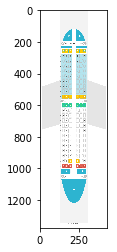

Début du pipeline : 
Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


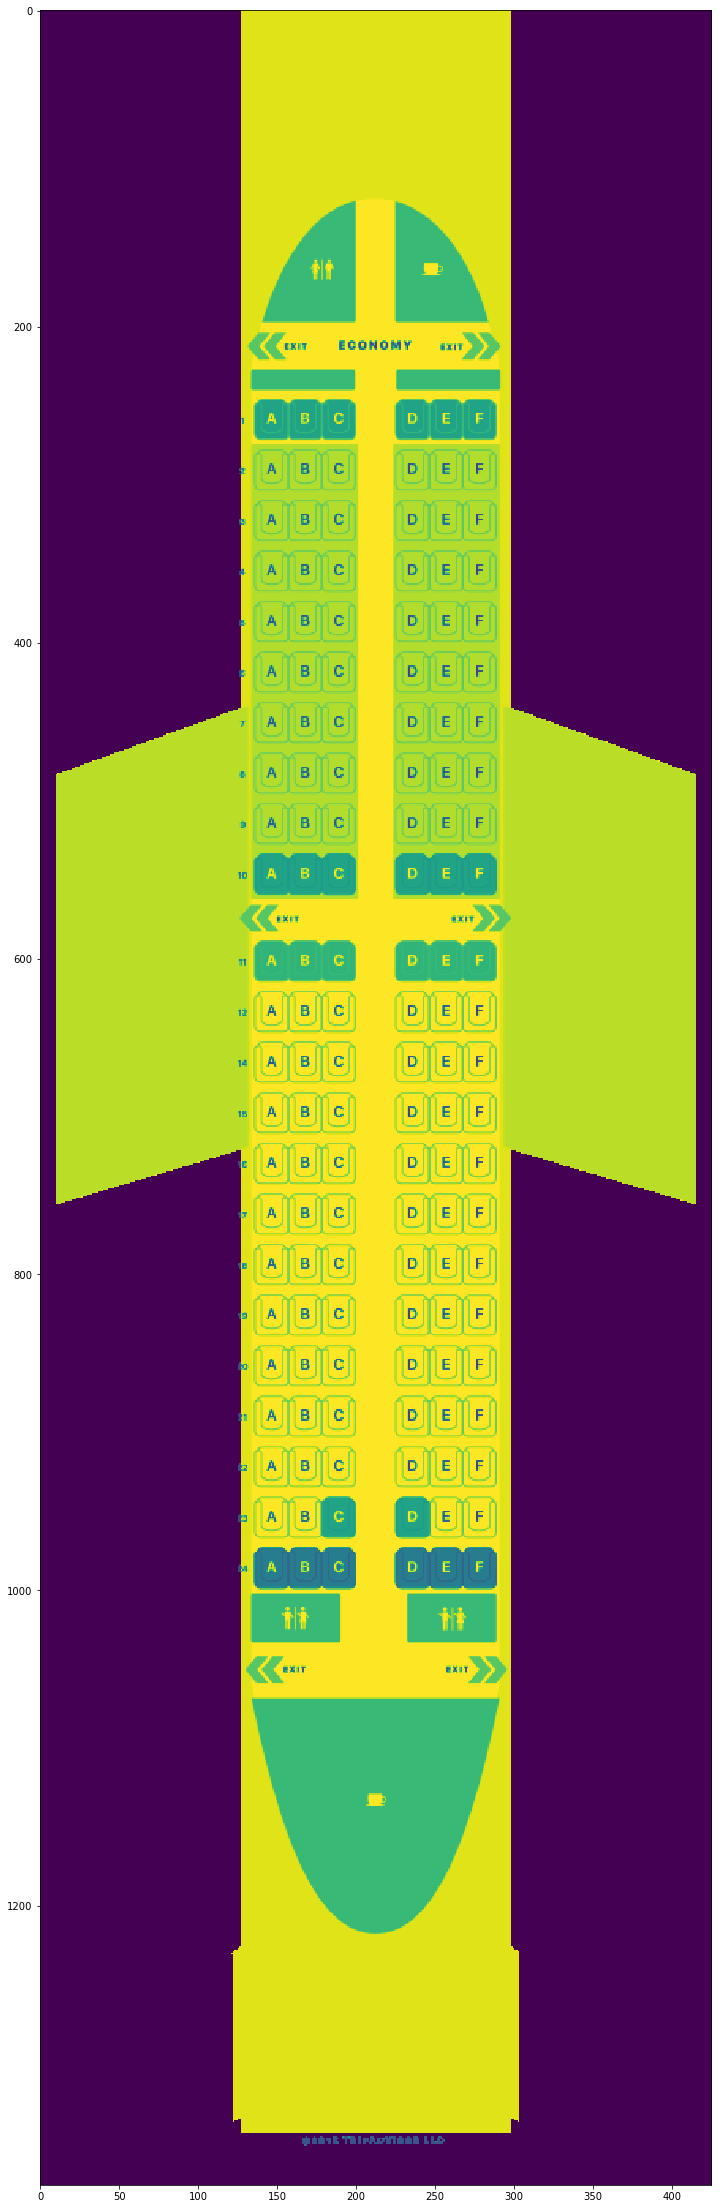

Process :  OpenCV4.1.2.30 -> pattern matching normal seat
Doing : OpenCV4.1.2.30 -> pattern matching normal seat
C:/Users/ng85ffc/Desktop/Data/LAYOUT_SEATGURU/Aegean_Airlines_Airbus_A319-100_plane1.svg.png shape (1377, 425)
temp_normal_seat.jpg 24 21 (1377, 425)
temp_normal_seat_elec.jpg 17 14 (1377, 425)
temp_normal_seat_little.jpg 16 14 (1377, 425)
temp_business_seat_armrest_left.jpg 21 27 (1377, 425)
temp_business_seat_armrest_right.jpg 21 26 (1377, 425)
temp_business_seat_footrest.jpg 50 33 (1377, 425)
temp_business_turn_left.jpg 35 28 (1377, 425)
temp_business_turn_right.jpg 35 28 (1377, 425)
{'temp_normal_seat.jpg': [], 'temp_normal_seat_elec.jpg': [], 'temp_normal_seat_little.jpg': [(140, 252), (161, 252), (182, 252), (229, 252), (250, 252), (271, 252)], 'temp_business_seat_armrest_left.jpg': [], 'temp_business_seat_armrest_right.jpg': [], 'temp_business_seat_footrest.jpg': [], 'temp_business_turn_left.jpg': [], 'temp_business_turn_right.jpg': []}
Postprocess :  Standard Python 

In [161]:
pipeline.run_pipeline(1, templates = ['temp_normal_seat.jpg', 'temp_normal_seat_a.jpg', 'temp_normal_seat_b.jpg', 'temp_normal_seat_c.jpg', 'temp_normal_seat_d.jpg', 'temp_normal_seat_e.jpg', 'temp_normal_seat_elec.jpg', 'temp_normal_seat_f.jpg', 'temp_normal_seat_little.jpg', 'temp_normal_seat_red.jpg','temp_business_seat_armrest_left.jpg', 'temp_business_seat_armrest_right.jpg', 'temp_business_seat_footrest.jpg', 'temp_business_seat_footrest2.jpg', 'temp_business_seat_footrest3.jpg', 'temp_business_turn_left.jpg', 'temp_business_turn_left1.jpg', 'temp_business_turn_right.jpg', 'temp_business_turn_right1.jpg'])

Standard Python >= 3.5 -> preprocess colours a été ajouté.
OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas a été ajouté.


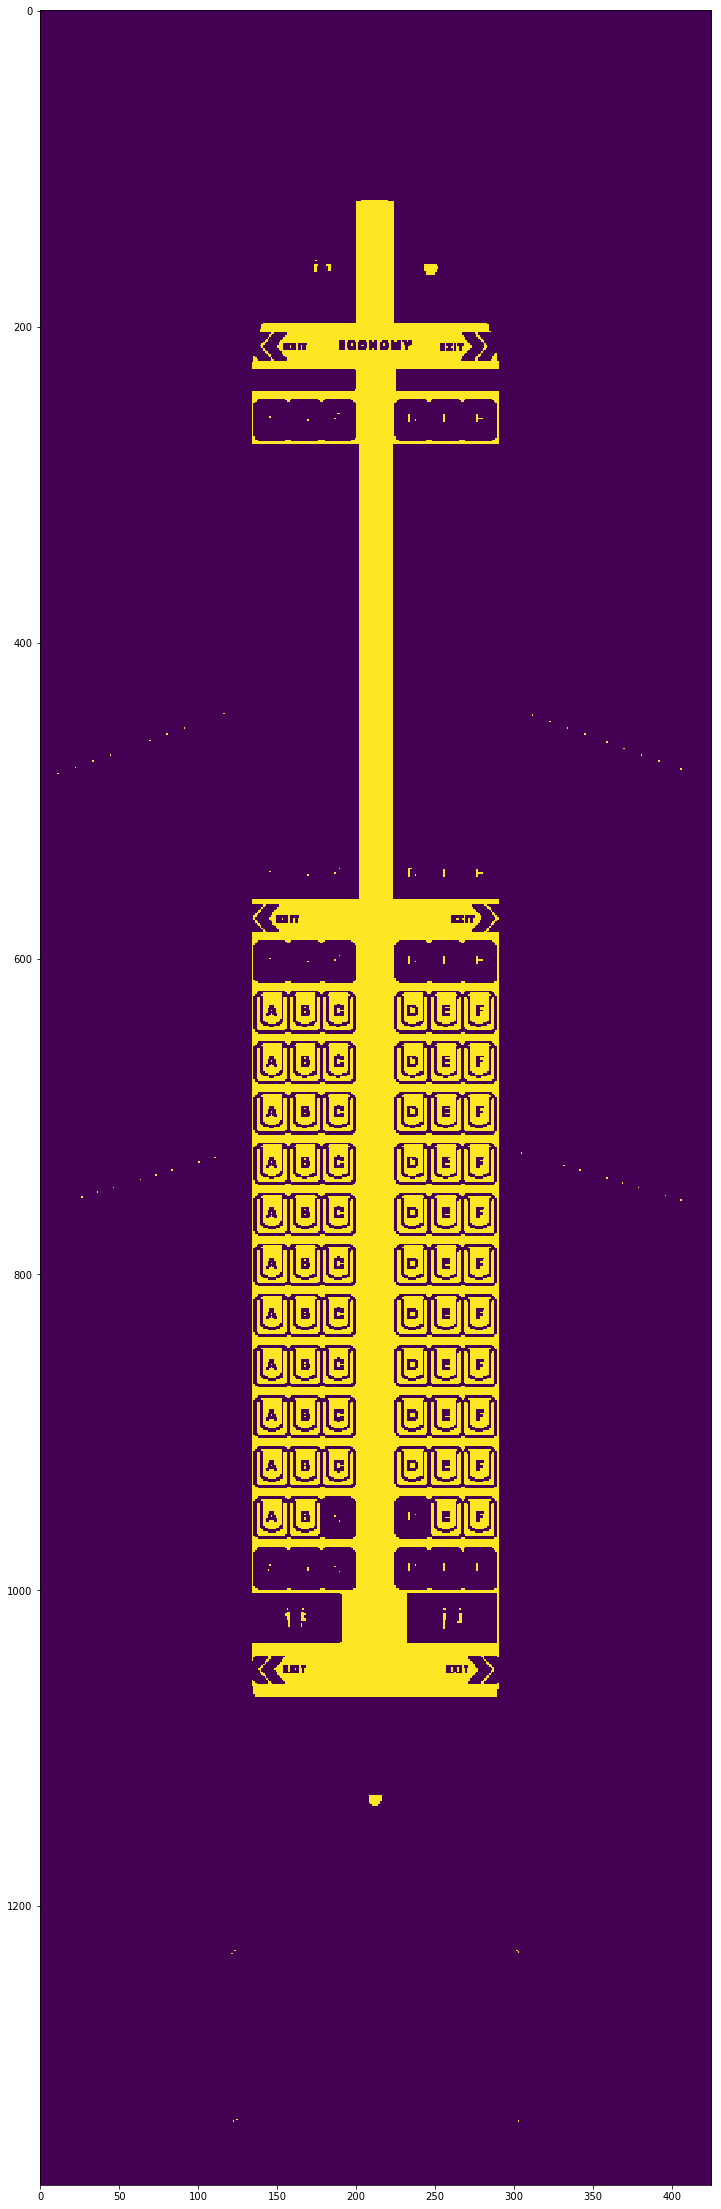

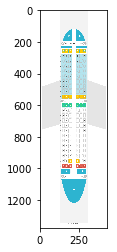

Début du pipeline : 
Preprocess :  Standard Python >= 3.5 -> preprocess colours
Doing : Standard Python >= 3.5 -> preprocess colours


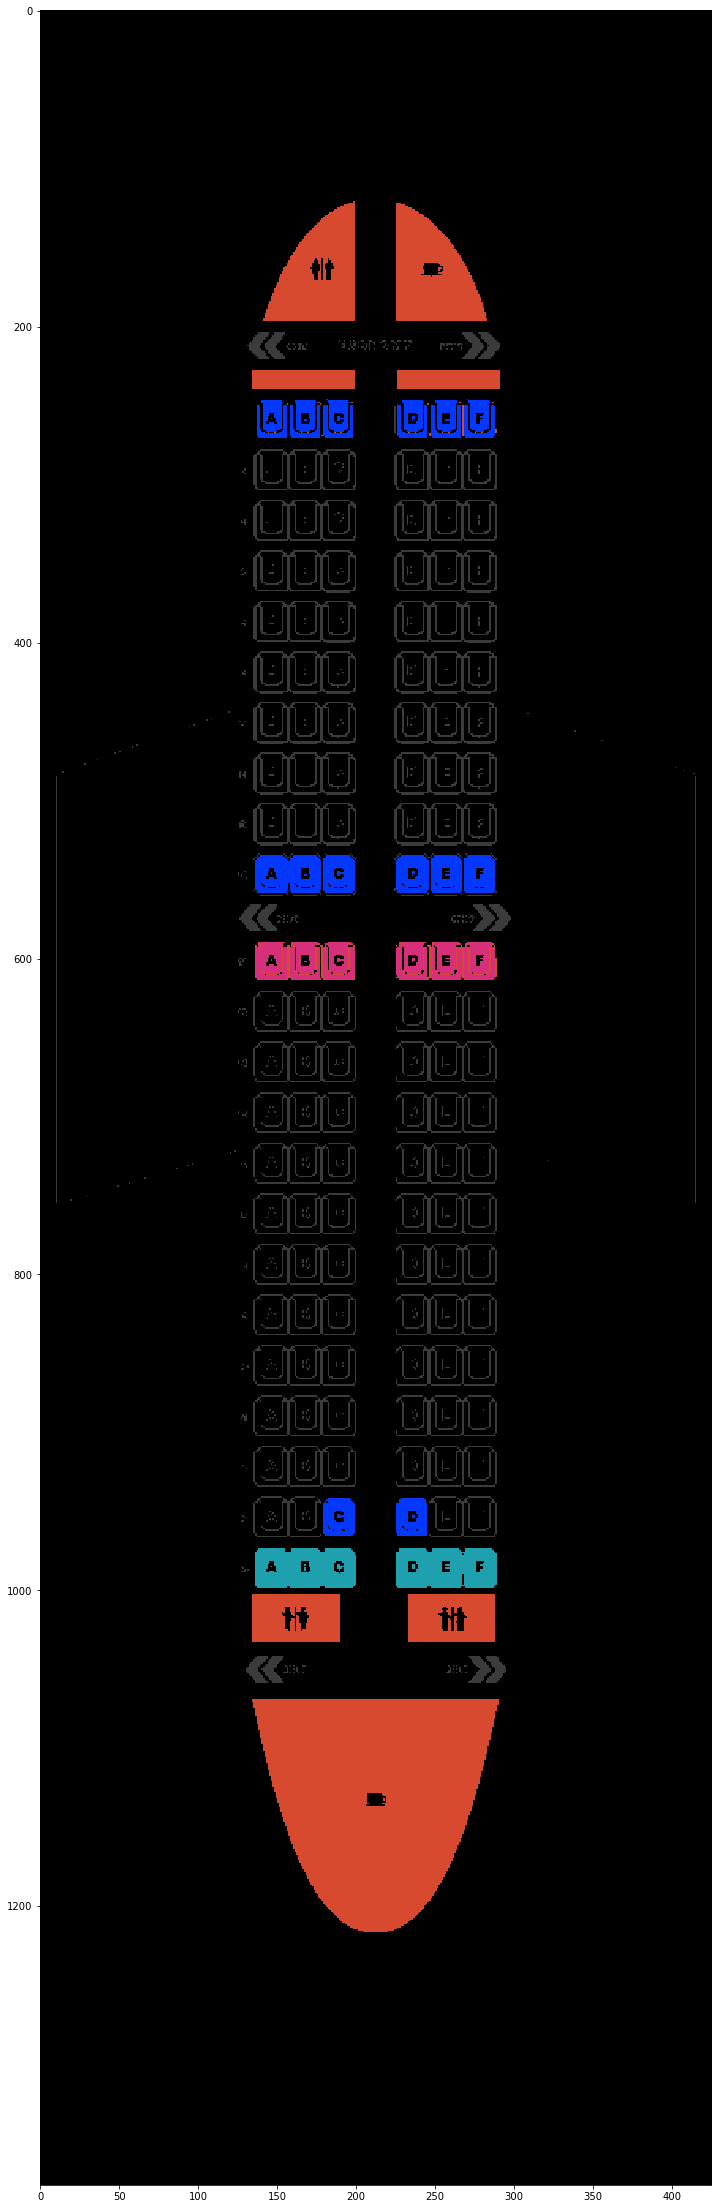

Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


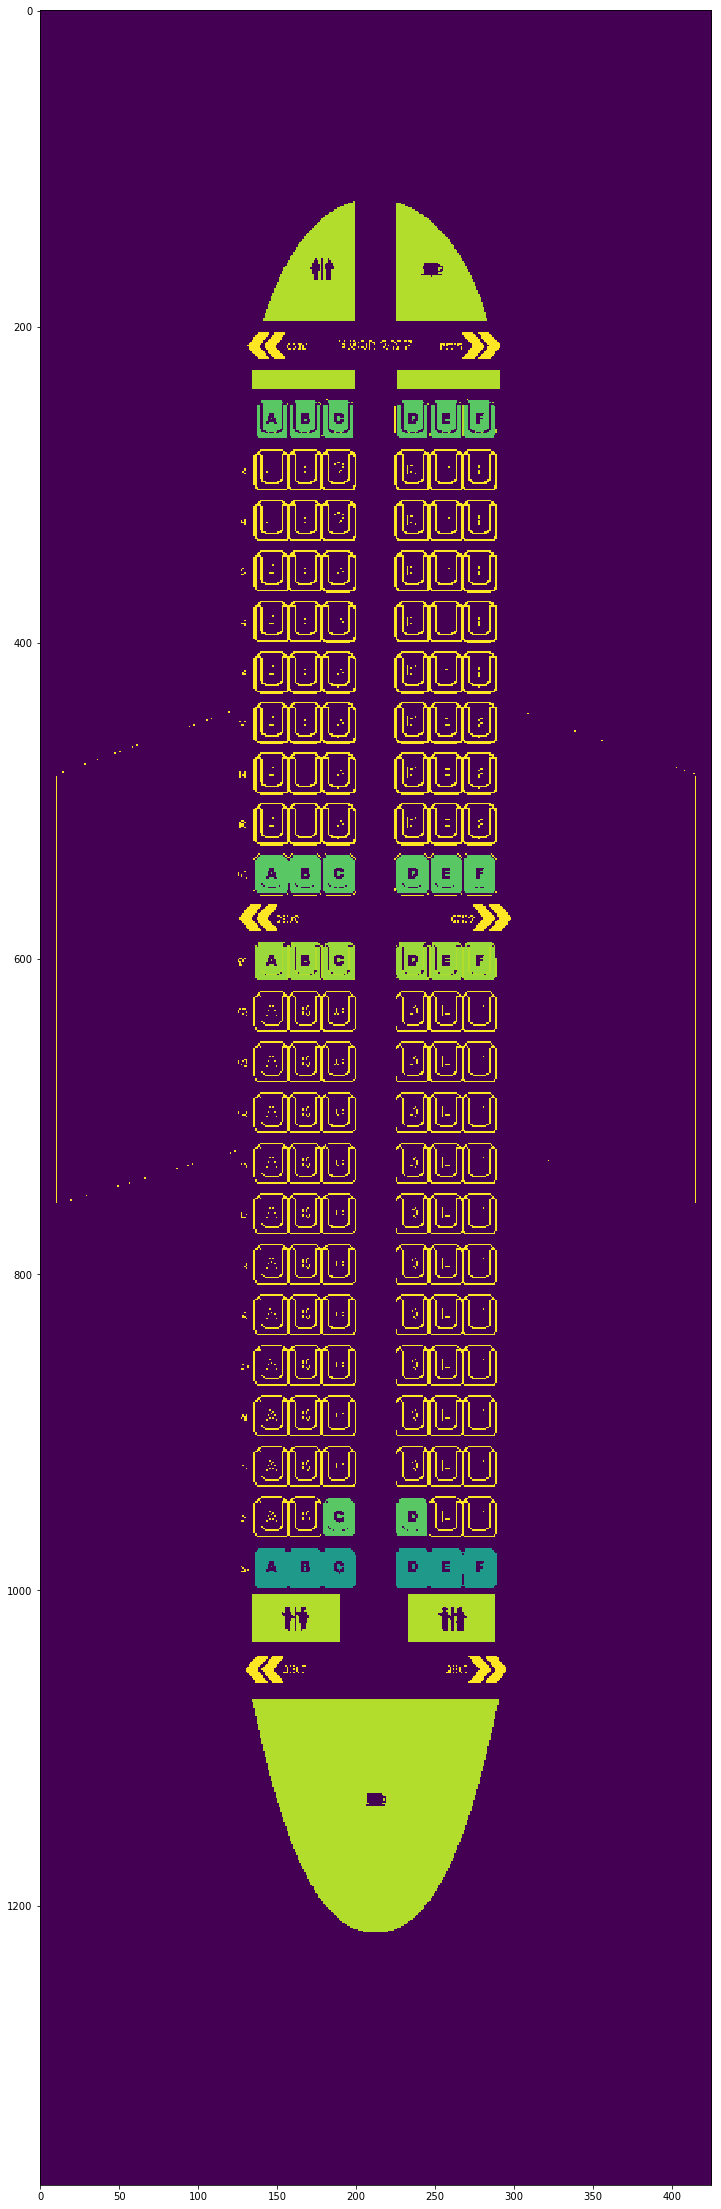

Process :  OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas
Doing : OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


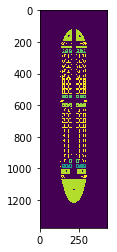

In [162]:
pipeline_zone = Pipeline("C:/Users/ng85ffc/Desktop/Data/","Oman_Air_Boeing_737-700_new_plane686.jpg")

pipeline_zone.add_processes([ColourPipelineZones, BlackWhite,SegmentationZone])
pipeline_zone.run_pipeline(1)

In [163]:
class DistPipeline():

    def find_cluster(self, epsilon: int, min_sample: int, list_wo_dup: list):
        """Documentation
        Parameters:
            epsilon: the maximum distance between two samples for one to be considered as in the neighborhood of the other
            min_sample: the number of samples in a neighborhood for a point to be considered as a core point
            list_wo_dup: list of seats coordinates not duplicated
        Out:
            dbscan: clustering result with DBSCAN
        """
        x_wo_dup = [a for a, b in list_wo_dup]
        y_wo_dup = [b for a, b in list_wo_dup]
        dbscan = DBSCAN(eps=epsilon, min_samples=min_sample).fit(list_wo_dup)
        plt.scatter(x_wo_dup, y_wo_dup, c=dbscan.labels_.astype(
            float), s=50, alpha=0.5)
        plt.show()
        return(dbscan)

    def clusters_to_rect(self, dbscan: sklearn.cluster.dbscan_.DBSCAN, array_wo_dup: np.array):
        """Documentation
        Parameters:
            dbscan: clustering result with DBSCAN
        Out:
            list_rect: list of rectangles representing each cluster
        """
        list_coord = array_wo_dup
        label_groups = pd.Series(dbscan.labels_).unique()
        list_rect = []  # to plot with plt.patches
        list_rect2 = []  # all corners of the rectangles
        HEIGHT: int = 30
        WIDTH: int = 20
        for group in label_groups:
            index = [i for i, x in enumerate(
                list(dbscan.labels_)) if x == group]
            points_cluster = list_coord[index]
            corner_bottom_right = (max(i[0] for i in points_cluster) + WIDTH, min(
                i[1] for i in points_cluster) - HEIGHT)
            corner_top_right = (max(i[0] for i in points_cluster) + WIDTH, max(
                i[1] for i in points_cluster))
            corner_top_left = (min(i[0] for i in points_cluster), max(
                i[1] for i in points_cluster))
            corner_bottom_left = (min(i[0] for i in points_cluster), min(
                i[1] for i in points_cluster) - HEIGHT)
            height = corner_top_right[1] - corner_bottom_right[1]
            width = corner_bottom_right[0] - corner_bottom_left[0]
            list_rect.append(((corner_bottom_left), width, height))
            list_rect2.append(
                (corner_bottom_left, corner_top_left, corner_top_right, corner_bottom_right))
        return list_rect, list_rect2

    def centroid_obstacle(self, coord_obs: list):
        """Documentation
        Parameters:
            coord_obs: cooardinate of the obstacle (list of tuple)
        Out:
            coord_bar_obs: barycenter cooardinate of the obstacle
        """
        A_point = coord_obs[0][1], coord_obs[0][0]
        B_point = coord_obs[1][1], coord_obs[1][0]
        coord_bar_obs = int(np.mean([A_point[0], B_point[0]])), int(
            np.mean([A_point[1], B_point[1]]))
        return coord_bar_obs

    def centroid_seat(self, coord_seat: tuple):
        """Documentation
        Parameters:
            coord_seat: cooardinate of the seat
        Out:
            coord_bar_seat: barycenter cooardinate of the seat
        """
        x, y = coord_seat[0], coord_seat[1]
        h, w = 30, 20
        coord_bar_seat = int(np.mean([x, x+w])), int(np.mean([y, y+h]))
        return coord_bar_seat

    def dist_crow_flies(self, coord_bar_seat: tuple, coord_bar_obs: tuple):
        """Documentation
        Parameters:
            coord_bar_seat: barycenter coordinate of the seat
            coord_bar_obs: barycenter cooardinate of the obstacle
        Out:
            dist: distance between the two barycenter
        """
        dist = np.sqrt(((coord_bar_obs[0]-coord_bar_seat[0])
                        ** 2)+((coord_bar_obs[1]-coord_bar_seat[1])**2))
        return round(dist, 2)

    def to_json(self, json_seat: dict, json_zone: dict, HEIGHT: int = 30, WIDTH: int = 20):
        """Documentation
        Parameters:
            pipeline_zone.json: json ???
            pipeline.json: json ???
        Out:
            dicimg: json final structure
        """
        dicimg = {}
        for img in list(pipeline_zone.json.keys()):
            dictypeseat = {}
            for typeseat in range(len(list(pipeline.json.keys()))):
                dicseat = {}
                for seat in list(pipeline.json.values())[typeseat]:
                    j = 0
                    dicobs = {}
                    for obs in pipeline_zone.json[list(pipeline_zone.json.keys())[0]]["rectangles"]:
                        j += 1
                        dicobs[("obstacle"+str(j))] = [centroid_obstacle([obs[0:2], obs[2:4]]),
                                                       dist_crow_flies(centroid_seat(seat), centroid_obstacle([obs[0:2], obs[2:4]]))]
                    dicseat[(centroid_seat(seat), WIDTH, HEIGHT)] = dicobs
                dictypeseat[list(pipeline.json.keys())[typeseat]] = dicseat
            dicimg[img] = dictypeseat
        return dicimg

In [164]:
coucou = DistPipeline()

coucou.to_json(pipeline.json, pipeline_zone.json)

{'Aegean_Airlines_Airbus_A319-100_plane1.svg.png': {'temp_business_seat_armrest_left.jpg': {},
  'temp_business_seat_armrest_right.jpg': {},
  'temp_business_seat_footrest.jpg': {},
  'temp_business_turn_left.jpg': {},
  'temp_business_turn_right.jpg': {},
  'temp_normal_seat.jpg': {},
  'temp_normal_seat_elec.jpg': {},
  'temp_normal_seat_little.jpg': {((150, 267),
    20,
    30): {'obstacle1': [(170, 159), 109.84], 'obstacle10': [(147, 259),
     8.5399999999999991], 'obstacle11': [(167, 291),
     29.41], 'obstacle12': [(256,
      291), 108.68000000000001], 'obstacle13': [(167, 323),
     58.520000000000003], 'obstacle14': [(256, 323),
     119.88], 'obstacle15': [(167,
      355), 89.629999999999995], 'obstacle16': [(256, 355),
     137.77000000000001], 'obstacle17': [(167, 387),
     121.2], 'obstacle18': [(256,
      387), 160.11000000000001], 'obstacle19': [(167, 419),
     152.94999999999999], 'obstacle2': [(254, 159),
     149.93000000000001], 'obstacle20': [(256, 419),
    